In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2, SelectKBest, mutual_info_classif, RFE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import joblib
import warnings
warnings.filterwarnings("ignore")

In [ ]:
file_path = "/kaggle/input/phishing-url-websites-dataset-phiusiil/PhiUSIIL_Phishing_URL_Dataset.csv"
df = pd.read_csv(file_path)

In [ ]:
print("Dataset Overview:")
print(df.info())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235795 entries, 0 to 235794
Data columns (total 56 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   FILENAME                    235795 non-null  object 
 1   URL                         235795 non-null  object 
 2   URLLength                   235795 non-null  int64  
 3   Domain                      235795 non-null  object 
 4   DomainLength                235795 non-null  int64  
 5   IsDomainIP                  235795 non-null  int64  
 6   TLD                         235795 non-null  object 
 7   URLSimilarityIndex          235795 non-null  float64
 8   CharContinuationRate        235795 non-null  float64
 9   TLDLegitimateProb           235795 non-null  float64
 10  URLCharProb                 235795 non-null  float64
 11  TLDLength                   235795 non-null  int64  
 12  NoOfSubDomain               235795 non-null  int64  
 

In [4]:
print(df.head(5))

     FILENAME                                 URL  URLLength  \
0  521848.txt    https://www.southbankmosaics.com         31   
1   31372.txt            https://www.uni-mainz.de         23   
2  597387.txt      https://www.voicefmradio.co.uk         29   
3  554095.txt         https://www.sfnmjournal.com         26   
4  151578.txt  https://www.rewildingargentina.org         33   

                       Domain  DomainLength  IsDomainIP  TLD  \
0    www.southbankmosaics.com            24           0  com   
1            www.uni-mainz.de            16           0   de   
2      www.voicefmradio.co.uk            22           0   uk   
3         www.sfnmjournal.com            19           0  com   
4  www.rewildingargentina.org            26           0  org   

   URLSimilarityIndex  CharContinuationRate  TLDLegitimateProb  ...  Pay  \
0               100.0              1.000000           0.522907  ...    0   
1               100.0              0.666667           0.032650  ...    0   
2 

In [5]:
print(df.tail(5))

           FILENAME                                                URL  \
235790   660997.txt                     https://www.skincareliving.com   
235791    77185.txt                      https://www.winchester.gov.uk   
235792   622132.txt                    https://www.nononsensedesign.be   
235793  7503962.txt  https://patient-cell-40f5.updatedlogmylogin.wo...   
235794   384822.txt                 https://www.alternativefinland.com   

        URLLength                                           Domain  \
235790         29                           www.skincareliving.com   
235791         28                            www.winchester.gov.uk   
235792         30                          www.nononsensedesign.be   
235793         55  patient-cell-40f5.updatedlogmylogin.workers.dev   
235794         33                       www.alternativefinland.com   

        DomainLength  IsDomainIP  TLD  URLSimilarityIndex  \
235790            22           0  com          100.000000   
235791      

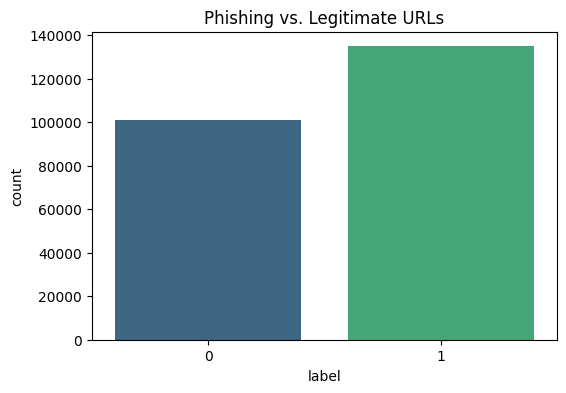

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df, palette='viridis')
plt.title("Phishing vs. Legitimate URLs")
plt.show()

In [7]:
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

Rows: 235795, Columns: 56


In [ ]:
duplicates_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates_count}")

Number of duplicate rows: 0


In [ ]:
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
print("Missing Values (%):\n", missing_percentage[missing_percentage > 0])

Missing Values (%):
 Series([], dtype: float64)


In [10]:
print(f"Remaining rows: {df.shape[0]}, Remaining columns: {df.shape[1]}")


Remaining rows: 235795, Remaining columns: 56


In [ ]:
if 'URL' in df.columns:
    print("Sample URLs:")
    print(df['URL'].head())
    df['URL'] = df['URL'].str.lower()  # Normalize URLs to lowercase

Sample URLs:
0      https://www.southbankmosaics.com
1              https://www.uni-mainz.de
2        https://www.voicefmradio.co.uk
3           https://www.sfnmjournal.com
4    https://www.rewildingargentina.org
Name: URL, dtype: object


In [5]:
if 'Domain' in df.columns:
    print("Sample Domains:")
    print(df['Domain'].head())
    df['Domain'] = df['Domain'].str.lower()  # Normalize domain names

Sample Domains:
0      www.southbankmosaics.com
1              www.uni-mainz.de
2        www.voicefmradio.co.uk
3           www.sfnmjournal.com
4    www.rewildingargentina.org
Name: Domain, dtype: object


In [ ]:
if 'TLD' in df.columns:
    print("Unique TLDs:", df['TLD'].unique())  


Unique TLDs: ['com' 'de' 'uk' 'org' 'in' 'ie' 'hu' 'ru' 'gq' 'es' 'jp' 'guru' 'app'
 'io' 'club' 'fr' 'au' 'today' 'cloud' 'br' 'pt' 'co' 'lt' 'ca' 'xyz' 'sk'
 'pl' 'dk' 'dev' 'ga' 'edu' 'space' 'ws' '123' 'cf' 'rs' 'games' 'nl' 'me'
 'net' 'life' 'ua' 'id' 'mx' 'asia' 'store' 'nz' 'eus' 'qa' 'fi' 'ch'
 'site' 'shop' 'hr' 'cz' 'im' 'ee' 'sg' 'travel' 'tz' 'top' 'info' 'tokyo'
 'at' 'gr' 'cc' 'tv' 'online' 'lk' 'review' 'us' 'bar' 'link' 'ng' 'cl'
 'ar' 'one' 'ph' 'tr' 'mil' 'se' '94' 'live' 'cn' 'ir' 'it' 'gd' 'eu'
 'win' 'no' 'su' 'gov' 'bg' 'ro' 'kr' 'eg' 'biz' 'il' 'page' 'pm' 'sh'
 'pk' 'my' 'quest' 'be' 'sa' 'tk' 'vip' 'agency' 'cyou' 'kz' 'uy'
 'network' '128' 'ml' 'hk' 'media' 'az' 'aero' 'news' 'lu' 'is' 'coop'
 'art' 'download' 'si' 'fm' 'bt' 'am' 'finance' 'mn' 'kh' 'ug' 'ae' 'cool'
 'za' 'th' 'energy' 'lv' 'global' 'tw' 'ke' 'moe' 'icu' '103' 'fun' '130'
 'cm' 'int' 'xn--c1avg' 'vg' 'gi' 'red' 'gal' 'sy' 'na' 'bo' 'land' 'je'
 'st' 'by' 'ly' 'bid' 'bio' 'world' 'law' 'digita

In [ ]:
for col in df.columns:
    print(col)

print(f"\nTotal columns: {len(df.columns)}")

FILENAME
URL
URLLength
Domain
DomainLength
IsDomainIP
TLD
URLSimilarityIndex
CharContinuationRate
TLDLegitimateProb
URLCharProb
TLDLength
NoOfSubDomain
HasObfuscation
NoOfObfuscatedChar
ObfuscationRatio
NoOfLettersInURL
LetterRatioInURL
NoOfDegitsInURL
DegitRatioInURL
NoOfEqualsInURL
NoOfQMarkInURL
NoOfAmpersandInURL
NoOfOtherSpecialCharsInURL
SpacialCharRatioInURL
IsHTTPS
LineOfCode
LargestLineLength
HasTitle
Title
DomainTitleMatchScore
URLTitleMatchScore
HasFavicon
Robots
IsResponsive
NoOfURLRedirect
NoOfSelfRedirect
HasDescription
NoOfPopup
NoOfiFrame
HasExternalFormSubmit
HasSocialNet
HasSubmitButton
HasHiddenFields
HasPasswordField
Bank
Pay
Crypto
HasCopyrightInfo
NoOfImage
NoOfCSS
NoOfJS
NoOfSelfRef
NoOfEmptyRef
NoOfExternalRef
label

Total columns: 56


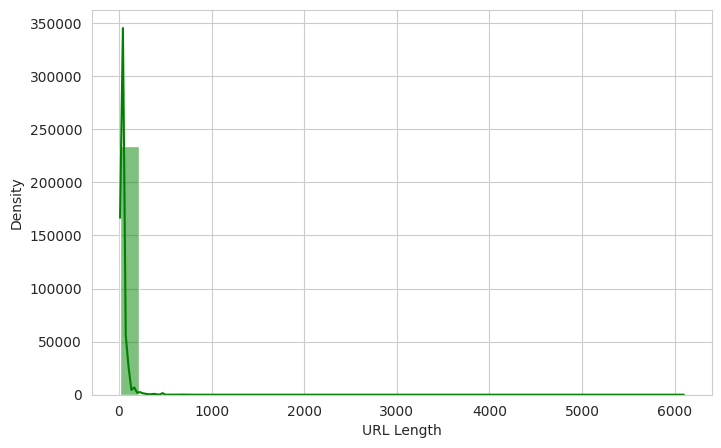

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

plt.figure(figsize=(8,5))
sns.histplot(df['URLLength'], bins=30, kde=True, color="green")
plt.xlabel("URL Length")
plt.ylabel("Density")
plt.show()

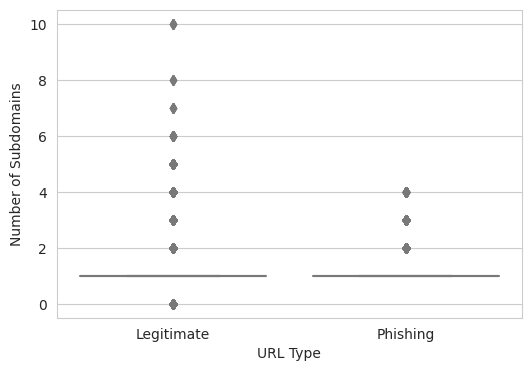

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df['label'], y=df['NoOfSubDomain'], palette="coolwarm")
plt.xticks([0, 1], ['Legitimate', 'Phishing'])
plt.xlabel("URL Type")
plt.ylabel("Number of Subdomains")
plt.show()

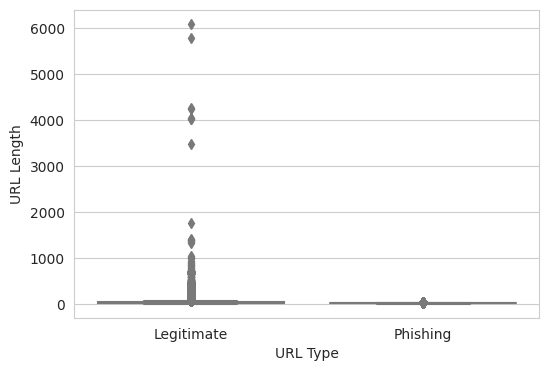

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df['label'], y=df['URLLength'], palette="coolwarm")
plt.xticks([0, 1], ['Legitimate', 'Phishing'])
plt.xlabel("URL Type")
plt.ylabel("URL Length")
plt.show()


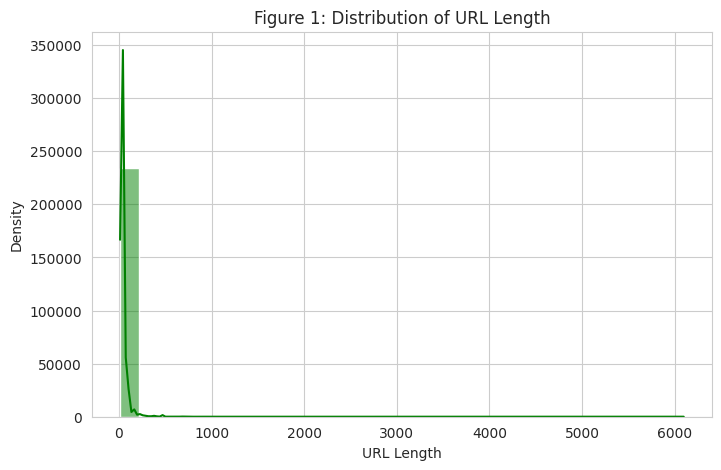

In [18]:
plt.figure(figsize=(8,5))
sns.histplot(df['URLLength'], bins=30, kde=True, color="green")
plt.title("Figure 1: Distribution of URL Length")
plt.xlabel("URL Length")
plt.ylabel("Density")
plt.show()


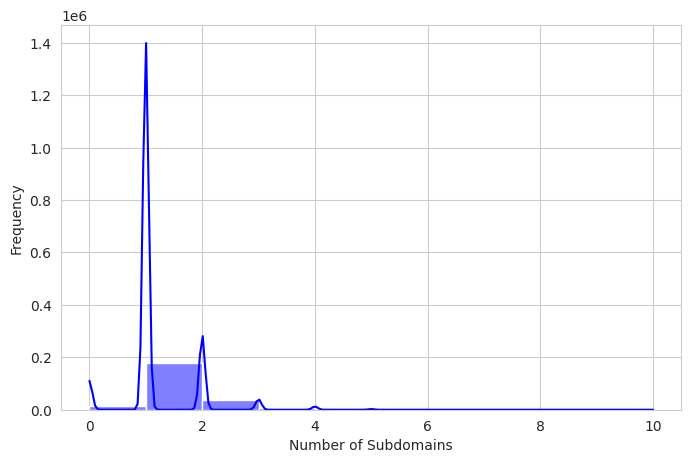

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['NoOfSubDomain'], bins=10, kde=True, color="blue")
plt.xlabel("Number of Subdomains")
plt.ylabel("Frequency")
plt.show()


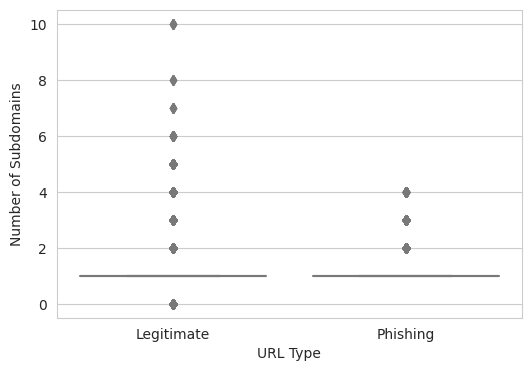

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df['label'], y=df['NoOfSubDomain'], palette="coolwarm")
plt.xticks([0, 1], ['Legitimate', 'Phishing'])
plt.xlabel("URL Type")
plt.ylabel("Number of Subdomains")
plt.show()


In [21]:
if 'TLD' in df.columns and 'label' in df.columns:
    phishing_tlds = df[df['label'] == 1]['TLD'].value_counts()
    legitimate_tlds = df[df['label'] == 0]['TLD'].value_counts()

    print("Top 10 TLDs in Phishing URLs:")
    print(phishing_tlds.head(10))

    print("\nTop 10 TLDs in Legitimate URLs:")
    print(legitimate_tlds.head(10))


Top 10 TLDs in Phishing URLs:
TLD
com    68785
org    16524
uk      6073
net     3998
de      3310
au      2606
jp      2082
edu     1856
it      1669
nl      1536
Name: count, dtype: int64

Top 10 TLDs in Legitimate URLs:
TLD
com     43769
app      6368
co       4964
io       3769
net      3099
ru       2983
top      2327
dev      2312
org      2269
site     1477
Name: count, dtype: int64


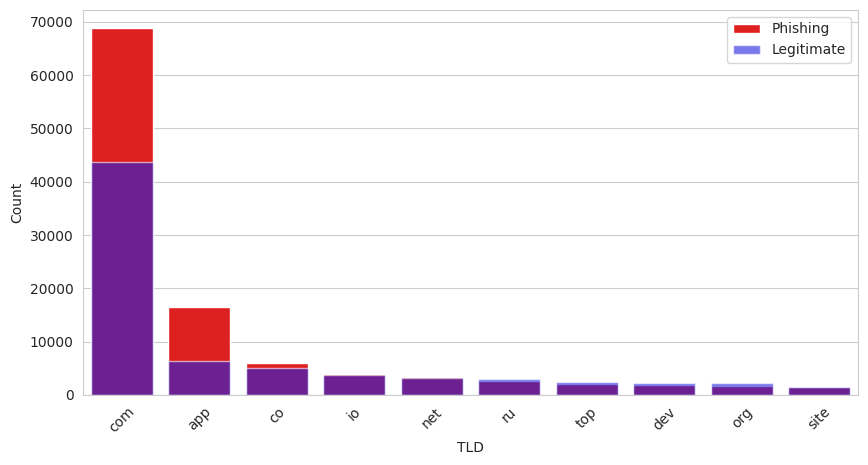

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x=phishing_tlds.index[:10], y=phishing_tlds.values[:10], color="red", label="Phishing")
sns.barplot(x=legitimate_tlds.index[:10], y=legitimate_tlds.values[:10], color="blue", alpha=0.6, label="Legitimate")
plt.xticks(rotation=45)
plt.legend()
plt.ylabel("Count")
plt.show()


In [6]:
high_risk_tlds = {'com', 'org', 'uk', 'net', 'de', 'au', 'jp', 'edu', 'it', 'nl'}
df['is_high_risk_tld'] = df['TLD'].apply(lambda x: 1 if x in high_risk_tlds else 0)


In [24]:
if 'NoOfSubDomain' in df.columns:
    print("Subdomain Count Statistics:")
    print(df['NoOfSubDomain'].describe())


Subdomain Count Statistics:
count    235795.000000
mean          1.164758
std           0.600969
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          10.000000
Name: NoOfSubDomain, dtype: float64


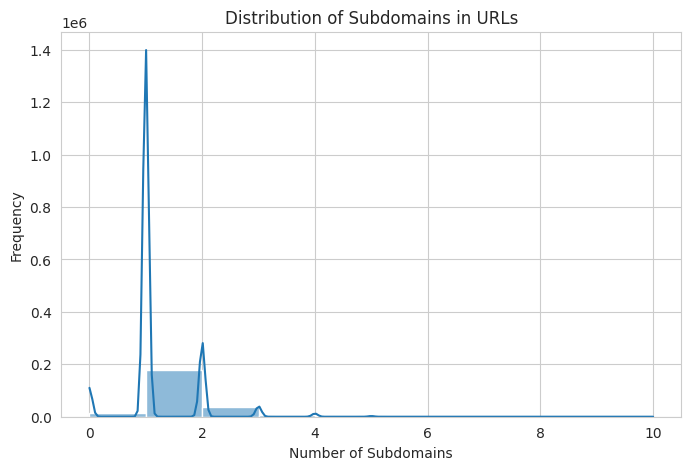

In [25]:
plt.figure(figsize=(8,5))
sns.histplot(df['NoOfSubDomain'], bins=10, kde=True)
plt.title("Distribution of Subdomains in URLs")
plt.xlabel("Number of Subdomains")
plt.ylabel("Frequency")
plt.show()


Mean Subdomains in Phishing URLs: 1.1616611049314052
Mean Subdomains in Legitimate URLs: 1.168893952152162


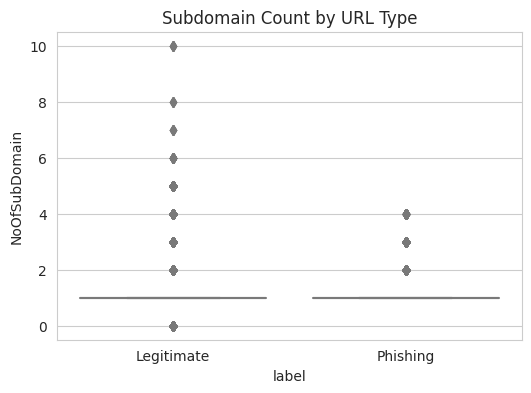

In [26]:
phishing_subdomains = df[df['label'] == 1]['NoOfSubDomain']
legitimate_subdomains = df[df['label'] == 0]['NoOfSubDomain']

print("Mean Subdomains in Phishing URLs:", phishing_subdomains.mean())
print("Mean Subdomains in Legitimate URLs:", legitimate_subdomains.mean())

plt.figure(figsize=(6,4))
sns.boxplot(x=df['label'], y=df['NoOfSubDomain'], palette="coolwarm")
plt.xticks([0, 1], ['Legitimate', 'Phishing'])
plt.title("Subdomain Count by URL Type")
plt.show()


In [7]:
df['has_many_subdomains'] = df['NoOfSubDomain'].apply(lambda x: 1 if x > 3 else 0)


In [ ]:
feature_columns = df.drop(columns=['label']).columns

for col in feature_columns:
    print(col)

print(f"\nTotal columns (excluding target): {len(feature_columns)}")


FILENAME
URL
URLLength
Domain
DomainLength
IsDomainIP
TLD
URLSimilarityIndex
CharContinuationRate
TLDLegitimateProb
URLCharProb
TLDLength
NoOfSubDomain
HasObfuscation
NoOfObfuscatedChar
ObfuscationRatio
NoOfLettersInURL
LetterRatioInURL
NoOfDegitsInURL
DegitRatioInURL
NoOfEqualsInURL
NoOfQMarkInURL
NoOfAmpersandInURL
NoOfOtherSpecialCharsInURL
SpacialCharRatioInURL
IsHTTPS
LineOfCode
LargestLineLength
HasTitle
Title
DomainTitleMatchScore
URLTitleMatchScore
HasFavicon
Robots
IsResponsive
NoOfURLRedirect
NoOfSelfRedirect
HasDescription
NoOfPopup
NoOfiFrame
HasExternalFormSubmit
HasSocialNet
HasSubmitButton
HasHiddenFields
HasPasswordField
Bank
Pay
Crypto
HasCopyrightInfo
NoOfImage
NoOfCSS
NoOfJS
NoOfSelfRef
NoOfEmptyRef
NoOfExternalRef
is_high_risk_tld
has_many_subdomains

Total columns (excluding target): 57


Total Column Feature was Without Target Class: 55;
By Adding 2 New Column Feature: 57

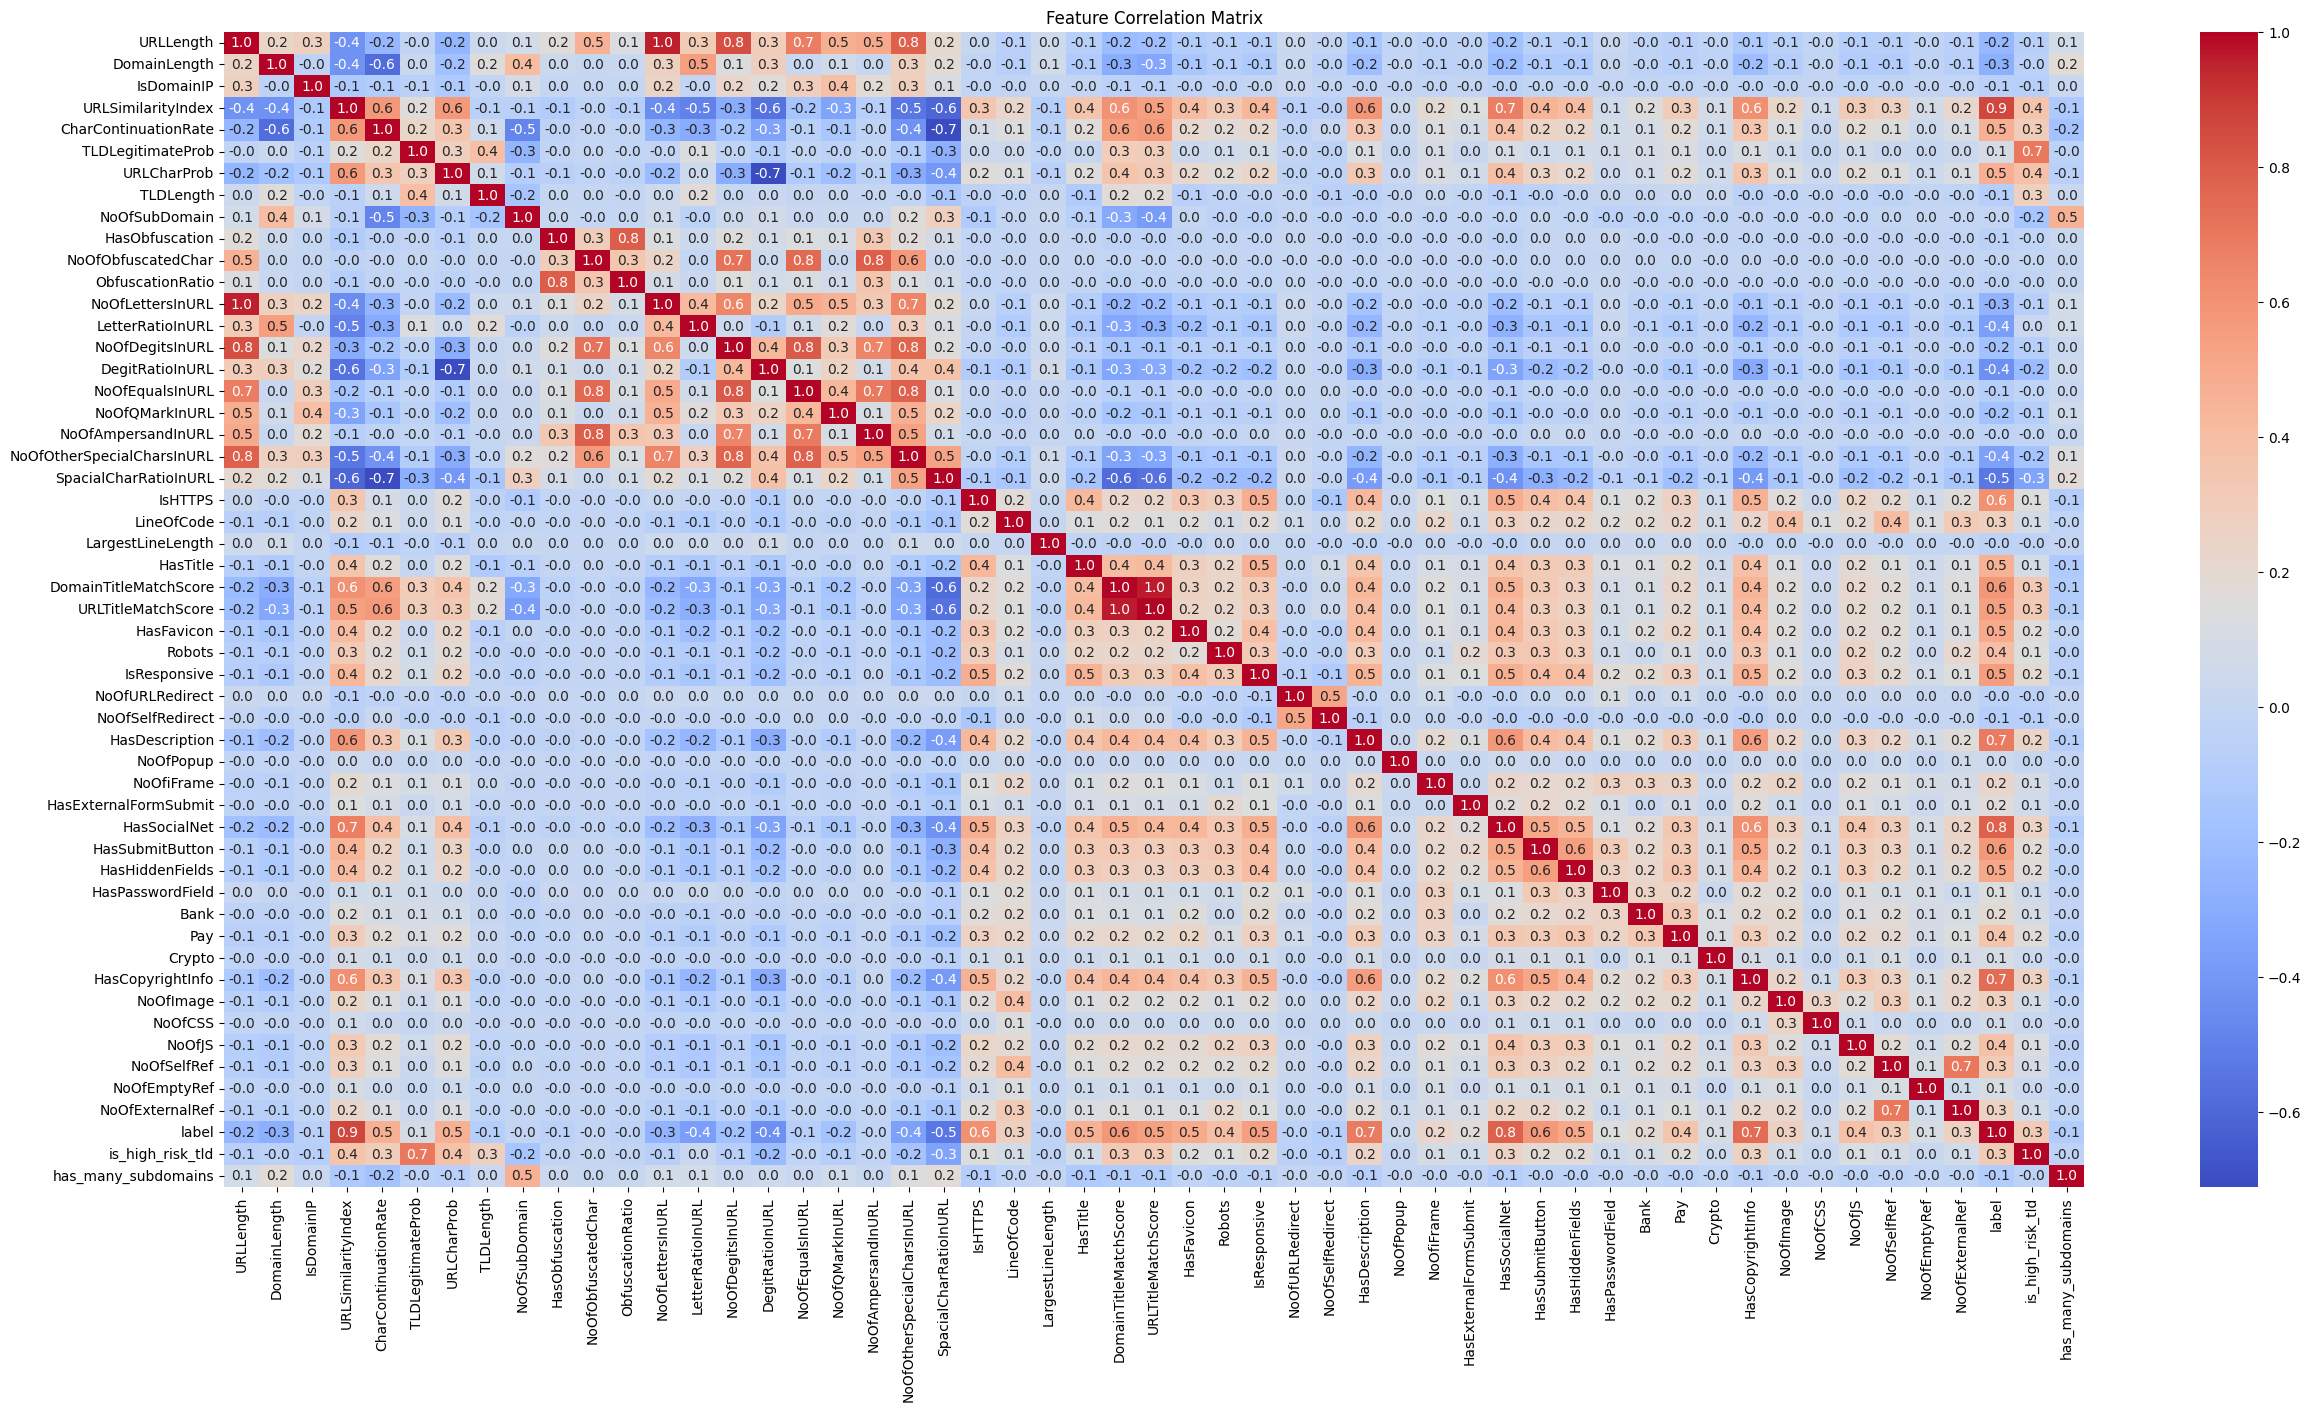

In [ ]:
numeric_df = df.select_dtypes(include=['number'])

correlation_matrix = numeric_df.corr()

plt.figure(figsize=(30, 15))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".1f")
plt.title("Feature Correlation Matrix")
plt.show()


In [ ]:
numeric_features = df.drop(columns=['label']).select_dtypes(include=['number'])

correlation_matrix = numeric_features.corr()

removed_features = set()
selected_features = set(numeric_features.columns)  # Exclude label explicitly

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.85:
            colname = correlation_matrix.columns[i]
            if colname in selected_features:
                removed_features.add(colname)
                selected_features.discard(colname)

df_reduced = df.drop(columns=removed_features)

removed_features

{'NoOfLettersInURL', 'URLTitleMatchScore'}

In [10]:
df = df_reduced

I removed these 2 features since they were highly correlated with other features to prevent performance degradation from redundant information. Total Feature is Now 55.

In [ ]:
feature_columns = df.drop(columns=['label']).columns

for col in feature_columns:
    print(col)

print(f"\nTotal columns (excluding target): {len(feature_columns)}")

FILENAME
URL
URLLength
Domain
DomainLength
IsDomainIP
TLD
URLSimilarityIndex
CharContinuationRate
TLDLegitimateProb
URLCharProb
TLDLength
NoOfSubDomain
HasObfuscation
NoOfObfuscatedChar
ObfuscationRatio
LetterRatioInURL
NoOfDegitsInURL
DegitRatioInURL
NoOfEqualsInURL
NoOfQMarkInURL
NoOfAmpersandInURL
NoOfOtherSpecialCharsInURL
SpacialCharRatioInURL
IsHTTPS
LineOfCode
LargestLineLength
HasTitle
Title
DomainTitleMatchScore
HasFavicon
Robots
IsResponsive
NoOfURLRedirect
NoOfSelfRedirect
HasDescription
NoOfPopup
NoOfiFrame
HasExternalFormSubmit
HasSocialNet
HasSubmitButton
HasHiddenFields
HasPasswordField
Bank
Pay
Crypto
HasCopyrightInfo
NoOfImage
NoOfCSS
NoOfJS
NoOfSelfRef
NoOfEmptyRef
NoOfExternalRef
is_high_risk_tld
has_many_subdomains

Total columns (excluding target): 55


In [ ]:

X = df.drop(columns=['label'])
y = df['label']

In [ ]:

X_numeric = X.select_dtypes(include=['number'])


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

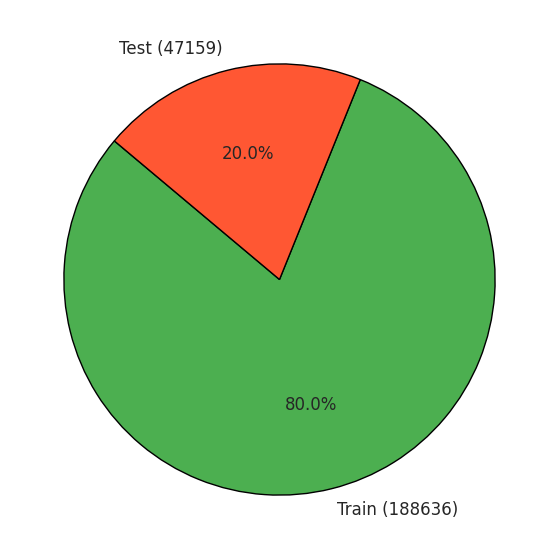

In [ ]:
import matplotlib.pyplot as plt


sizes = [len(X_train), len(X_test)]
labels = [f"Train ({sizes[0]})", f"Test ({sizes[1]})"]
colors = ["#4CAF50", "#FF5733"]  


plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", colors=colors, startangle=140,
        wedgeprops={"edgecolor": "black"}, textprops={'fontsize': 12})


plt.show()


In [ ]:

categorical_features = df.select_dtypes(include=['object', 'category'])

cardinality = categorical_features.nunique().sort_values(ascending=False)
print(cardinality)

FILENAME    235795
URL         235370
Domain      220086
Title       197874
TLD            695
dtype: int64


In [ ]:

df = df.drop(columns=["FILENAME", "URL", "Domain", "Title"])

So, I excluded high-cardinality categorical features and retained only the TLD column for further analysis.

In [ ]:

feature_columns = df.drop(columns=['label']).columns


for col in feature_columns:
    print(col)


print(f"\nTotal columns (excluding target): {len(feature_columns)}")

URLLength
DomainLength
IsDomainIP
TLD
URLSimilarityIndex
CharContinuationRate
TLDLegitimateProb
URLCharProb
TLDLength
NoOfSubDomain
HasObfuscation
NoOfObfuscatedChar
ObfuscationRatio
LetterRatioInURL
NoOfDegitsInURL
DegitRatioInURL
NoOfEqualsInURL
NoOfQMarkInURL
NoOfAmpersandInURL
NoOfOtherSpecialCharsInURL
SpacialCharRatioInURL
IsHTTPS
LineOfCode
LargestLineLength
HasTitle
DomainTitleMatchScore
HasFavicon
Robots
IsResponsive
NoOfURLRedirect
NoOfSelfRedirect
HasDescription
NoOfPopup
NoOfiFrame
HasExternalFormSubmit
HasSocialNet
HasSubmitButton
HasHiddenFields
HasPasswordField
Bank
Pay
Crypto
HasCopyrightInfo
NoOfImage
NoOfCSS
NoOfJS
NoOfSelfRef
NoOfEmptyRef
NoOfExternalRef
is_high_risk_tld
has_many_subdomains

Total columns (excluding target): 51


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


X = df.drop(columns=['label'])
y = df['label']


X_numeric = X.select_dtypes(include=['number'])
X_categorical = X[['TLD']]  


encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_tld_encoded = encoder.fit_transform(X_categorical)
tld_feature_names = encoder.get_feature_names_out(['TLD'])

joblib.dump(encoder, "/kaggle/working/tld_encoder.pkl")


X_combined = np.hstack((X_numeric, X_tld_encoded))
feature_names = list(X_numeric.columns) + list(tld_feature_names)


scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_combined)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


chi_selector = SelectKBest(score_func=chi2, k='all')
chi_selector.fit(X_train, y_train)
chi_scores = chi_selector.scores_


mi_selector = SelectKBest(score_func=mutual_info_classif, k='all')
mi_selector.fit(X_train, y_train)
mi_scores = mi_selector.scores_


chi_indices = np.argsort(chi_scores)[::-1]
mi_indices = np.argsort(mi_scores)[::-1]

top_chi = [feature_names[i] for i in chi_indices[:2]]
top_mi = [feature_names[i] for i in mi_indices[:2]]


combined_features = list(dict.fromkeys(top_chi + top_mi)) 


print("\n🔥 Top Chi-Square Features:")
print(top_chi)

print("\n🧠 Top Mutual Information Features:")
print(top_mi)

print(f"\n✅ Combined Unique Features ({len(combined_features)} total):")
print(combined_features)


selected_indices = [feature_names.index(f) for f in combined_features]

X_train_sel = X_train[:, selected_indices]
X_test_sel = X_test[:, selected_indices]


models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
}


print("\n📊 Results using selected features:")
for name, model in models.items():
    model.fit(X_train_sel, y_train)
    y_pred_test = model.predict(X_test_sel)
    y_pred_train = model.predict(X_train_sel)

    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    prec = precision_score(y_test, y_pred_test, average='weighted', zero_division=1)
    rec = recall_score(y_test, y_pred_test, average='weighted', zero_division=1)
    f1 = f1_score(y_test, y_pred_test, average='weighted', zero_division=1)

    print(f"- {name}:")
    print(f"   ✅ Train Accuracy = {train_acc*100:.2f}%")
    print(f"   📈 Test Accuracy = {test_acc*100:.2f}%")
    print(f"   🎯 Precision = {prec*100:.2f}% | Recall = {rec*100:.2f}% | F1 Score = {f1*100:.2f}%")



🔥 Top Chi-Square Features:
['TLD_mp', 'TLD_film']

🧠 Top Mutual Information Features:
['URLSimilarityIndex', 'LineOfCode']

✅ Combined Unique Features (4 total):
['TLD_mp', 'TLD_film', 'URLSimilarityIndex', 'LineOfCode']

📊 Results using selected features:
- Logistic Regression:
   ✅ Train Accuracy = 99.43%
   📈 Test Accuracy = 99.47%
   🎯 Precision = 99.47% | Recall = 99.47% | F1 Score = 99.47%
- Random Forest:
   ✅ Train Accuracy = 99.99%
   📈 Test Accuracy = 99.99%
   🎯 Precision = 99.99% | Recall = 99.99% | F1 Score = 99.99%
- SVM:
   ✅ Train Accuracy = 99.66%
   📈 Test Accuracy = 99.67%
   🎯 Precision = 99.67% | Recall = 99.67% | F1 Score = 99.67%
- KNN:
   ✅ Train Accuracy = 99.99%
   📈 Test Accuracy = 99.99%
   🎯 Precision = 99.99% | Recall = 99.99% | F1 Score = 99.99%
- Naive Bayes:
   ✅ Train Accuracy = 99.66%
   📈 Test Accuracy = 99.67%
   🎯 Precision = 99.68% | Recall = 99.67% | F1 Score = 99.67%


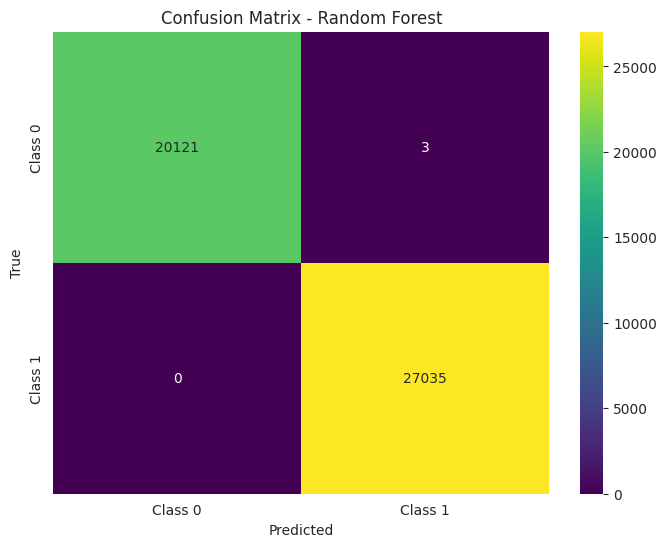

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


rf_model = RandomForestClassifier()
rf_model.fit(X_train_sel, y_train)


y_pred_rf = rf_model.predict(X_test_sel)


cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


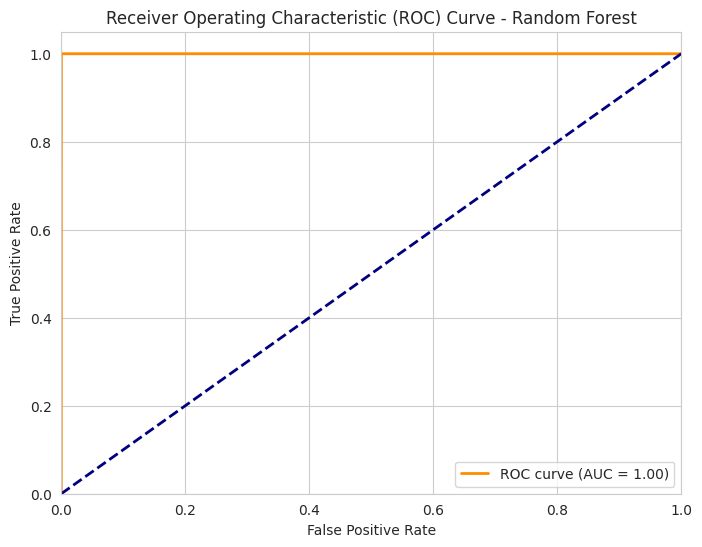

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


rf_model = RandomForestClassifier()
rf_model.fit(X_train_sel, y_train)


y_pred_prob = rf_model.predict_proba(X_test_sel)[:, 1]  


fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc='lower right')
plt.show()


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np


param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
}


rf_model = RandomForestClassifier(random_state=42)


random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=30,  
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42,
    scoring='accuracy'
)

random_search.fit(X_train_sel, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

print(f"\nBest Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score * 100:.2f}%")

best_rf_model = random_search.best_estimator_

y_pred_test = best_rf_model.predict(X_test_sel)
y_pred_train = best_rf_model.predict(X_train_sel)

train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)
prec = precision_score(y_test, y_pred_test, average='weighted', zero_division=1)
rec = recall_score(y_test, y_pred_test, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred_test, average='weighted', zero_division=1)

print(f"\nRandom Forest with Best Hyperparameters:")
print(f"   ✅ Train Accuracy = {train_acc*100:.2f}%")
print(f"   📈 Test Accuracy = {test_acc*100:.2f}%")
print(f"   🎯 Precision = {prec*100:.2f}% | Recall = {rec*100:.2f}% | F1 Score = {f1*100:.2f}%")


Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor


Best Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 30, 'bootstrap': False}
Best Cross-Validation Accuracy: 99.99%

Random Forest with Best Hyperparameters:
   ✅ Train Accuracy = 99.99%
   📈 Test Accuracy = 99.99%
   🎯 Precision = 99.99% | Recall = 99.99% | F1 Score = 99.99%
